In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

## Table of Contents
* [1. Load the data](#load)
    * [1.1 Characters dataset](#load_characters)
    * [1.2 Movies dataset](#load_movies)
* [2. Quick look at the data](#quicklook)
    * [2.1 Characters dataset](#quicklook_characters)
    * [2.2 Movies dataset](#quicklook_movies)
* [3. Data preprocessing](#datapreprocessing)
    * [3.1 Characters dataset](#datapreprocessing_characters)
    * [3.2 Movies dataset](#datapreprocessing_movies)
* [4. Data preparation](#datapreparation)
    * [4.1 Characters dataset](#datapreparation_characters)
    * [4.2 Actors dataset](#datapreparation_actors)
    * [4.3 Movies dataset](#datapreparation_movies)
* [5. Data exploration](#dataexploration)
    * [5.1 Characters distribution](#dataexploration_characters)
    * [5.2 Movies dataset](#dataexploration_movies)

# 1. Load the data
<a class="anchor" id="load"></a>

In [4]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
PLOT_PATH = os.path.join(DATA_PATH, 'plot_summaries.txt')
ETHNICITIES_PATH =  os.path.join(DATA_PATH, 'ethnicities.csv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [5]:
a_cols = ['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_chars=pd.read_csv(CHAR_PATH, sep='\t', names=a_cols)

### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [6]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv(MOVIE_PATH, sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})

# 2. Quick look at the data
<a class="anchor" id="quicklook"></a>

### 2.1 Characters dataset
<a class="anchor" id="quicklook_characters"></a>

In [7]:
df_chars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   wikipedia_m_ID          450669 non-null  int64  
 1   freebase_m_ID           450669 non-null  object 
 2   m_release_date          440674 non-null  object 
 3   character_name          192794 non-null  object 
 4   actor_dob               344524 non-null  object 
 5   actor_gender            405060 non-null  object 
 6   actor_height            154824 non-null  float64
 7   actor_ethnicity         106058 non-null  object 
 8   actor_name              449441 non-null  object 
 9   actor_age               292556 non-null  float64
 10  freebase_character_map  450669 non-null  object 
 11  freebase_character_id   192804 non-null  object 
 12  freebase_actor_id       449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [8]:
df_chars.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
333038,8279517,/m/026ytf0,1946-07-27,NaN,1917-07-26,F,NaN,NaN,Lorna Gray,29.0,/m/040g17v,NaN,/m/02x2cdx
236405,7140940,/m/04j2l3n,2000,NaN,NaN,NaN,NaN,NaN,Bill MacDonald,NaN,/m/0gc741p,NaN,/m/0gbxs5k
273428,1343628,/m/04v9nx,2004-03-12,Elsa,1971-12-18,F,NaN,NaN,Claudia Gerini,32.0,/m/02vb_rb,/m/0gz62sm,/m/02qh5b1
199888,3447732,/m/09cyky,1993-06-24,Mr. Henry Mitchell,1963-03-08,M,NaN,NaN,Robert Stanton,30.0,/m/0cg3wcy,/m/0h5spgt,/m/06wb6qq


### 2.2 Movies dataset
<a class="anchor" id="quicklook_movies"></a>

In [9]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikipedia_m_ID  81741 non-null  int64  
 1   freebase_m_ID   81741 non-null  object 
 2   m_name          81741 non-null  object 
 3   m_release_date  74839 non-null  object 
 4   m_BO_revenue    8401 non-null   float64
 5   m_runtime       61291 non-null  float64
 6   m_languages     81741 non-null  object 
 7   m_countries     81741 non-null  object 
 8   m_genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [10]:
df_movies.sample(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
68913,2101206,/m/06m608,The Compleat Al,1985-08,NaN,100.0,{'/m/02h40lc': 'English Language'},{},"{'/m/0gf28': 'Parody', '/m/0l4h_': 'Mockumenta..."
66932,26508388,/m/0bh862k,"Nefertiti, figlia del sole",1994,NaN,68.0,{'/m/02bjrlw': 'Italian Language'},"{'/m/0f8l9c': 'France', '/m/03rjj': 'Italy', '...",{'/m/068d7h': 'Romantic drama'}
60895,31355057,/m/07xgs84,Arthur 3: The War of the Two Worlds,2010-10-13,NaN,101.0,{'/m/02h40lc': 'English Language'},{'/m/0f8l9c': 'France'},"{'/m/0hqxf': 'Family Film', '/m/01hmnh': 'Fant..."
19073,30413149,/m/0crsrw4,Go Go 70s,2008-10-02,NaN,118.0,{'/m/02hwhyv': 'Korean Language'},{'/m/06qd3': 'South Korea'},"{'/m/07s9rl0': 'Drama', '/m/03q4nz': 'World ci..."


As shown with .info() function, it can be seen that data is in Mb order so it can be handled in size.

# 3. Data preprocessing
<a class="anchor" id="preprocessing"></a>

### 3.1 Characters dataset
<a class="anchor" id="preprocessing_characters"></a>

#### Columns conversion

In [11]:
#Change problematic dates
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_chars['actor_dob'] = df_chars['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors = 'coerce')

#### Actor age

In [12]:
# Number of characters whose actor has a negative age when appearing in the movie
nb_chars_negative_age = df_chars[df_chars['actor_age'] <= 0]['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a negative age.".format(nb_chars_negative_age))

There are 433 characters whose actor has a negative age.


#### Actor name

In [13]:
# Number of characters whose actor is named 'NaN'
df_chars['actor_name'].value_counts(dropna=False)[:10]

NaN                   1228
Mel Blanc              791
Mithun Chakraborty     328
Oliver Hardy           299
Mohanlal               234
Moe Howard             225
Mammootty              225
Dharmendra Deol        219
Larry Fine             219
Amitabh Bachchan       206
Name: actor_name, dtype: int64

In [14]:
# Number of characters whose actor is named 'NaN'
nb_chars_nan = df_chars['actor_name'].value_counts(dropna=False)[np.nan]
print("There are {} characters whose actor name is nan.".format(nb_chars_nan))

There are 1228 characters whose actor name is nan.


#### Duplicated characters

In [15]:
# Number of duplicates
nb_char_duplicates = df_chars.duplicated().sum()
print("There are {} duplicated characters. So there is no duplicated row.".format(nb_char_duplicates))

There are 0 duplicated characters. So there is no duplicated row.


In [16]:
# Number of occurrences with same subset of columns as described below
nb_char_duplicates_sub = df_chars.duplicated(subset=['wikipedia_m_ID', 'character_name', 'actor_name', 'm_release_date']).sum()
print("There are {} characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.".format(nb_char_duplicates_sub))

There are 1086 characters which appear in the same movie with the same release date, have the same name and which are played by the same actor.


#### Casting date of birth

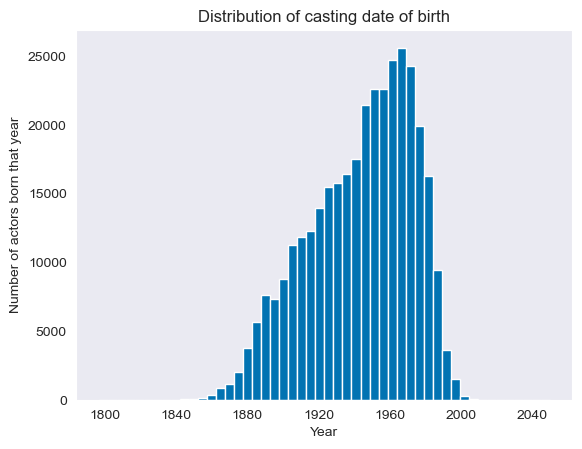

There are 1 actors born at the earliest on 1796-09-20.
The actor born the latest is Naozumi Takahashi on 2050-01-01.


In [17]:
# Sensible looking graph, there is no need to discard any data based on this feature
plt.title('Distribution of casting date of birth')
plt.xlabel('Year')
plt.ylabel('Number of actors born that year')
plt.hist(df_chars['actor_dob'], bins=50, color=BLUE)
plt.grid()
plt.show()
date_born_min = df_chars['actor_dob'].min()
nb_actors_min = df_chars[df_chars['actor_dob'] == date_born_min]['actor_dob'].count()
date_born_max = df_chars['actor_dob'].max()
name_actor_born_max = df_chars.loc[df_chars['actor_dob'] == date_born_max]['actor_name'].values[0]
print("There are {} actors born at the earliest on {}.\nThe actor born the latest is {} on {}.".format(nb_actors_min, date_born_min.strftime('%Y-%m-%d'), name_actor_born_max, date_born_max.strftime('%Y-%m-%d')))

The actor database contains following errors:
- **Actors with negative age**: is (at least in some cases (wikipedia_movie_id: 15007384)) due to actors having the same last name, which probably led to some scraping missmatch, e.g. a movie attributed to a son when it was in fact his father acting. We are going to drop those since it is clearly mistaken.
- **Actors with name 'Nan'**: there is no way for us to qualitatively use this data, so we will drop them.
- **Actors duplicates**: some duplicates were identified, we will safely remove them.

#### Cleaning

In [18]:
df_chars = df_chars[df_chars.actor_age > 0]
df_chars.dropna(subset='actor_name', inplace=True)
df_chars.drop_duplicates(subset=["wikipedia_m_ID", "character_name", "actor_name", "m_release_date"], keep=False, inplace=True)

### 3.2 Movies dataset
<a class="anchor" id="preprocessing_movies"></a>

#### Columns conversion

In [19]:
#Movie release dates are parsed as datetime.
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')

#### Movie freebase ID

In [20]:
%%time
#A sample of movies is taken to get their freebase ID. The average is then done on how much of them had a valid movie freebase ID.
tot = []
k_size = 8
n = 100
for k in range(k_size):
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url='%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

CPU times: user 753 ms, sys: 52 ms, total: 805 ms
Wall time: 1min 6s


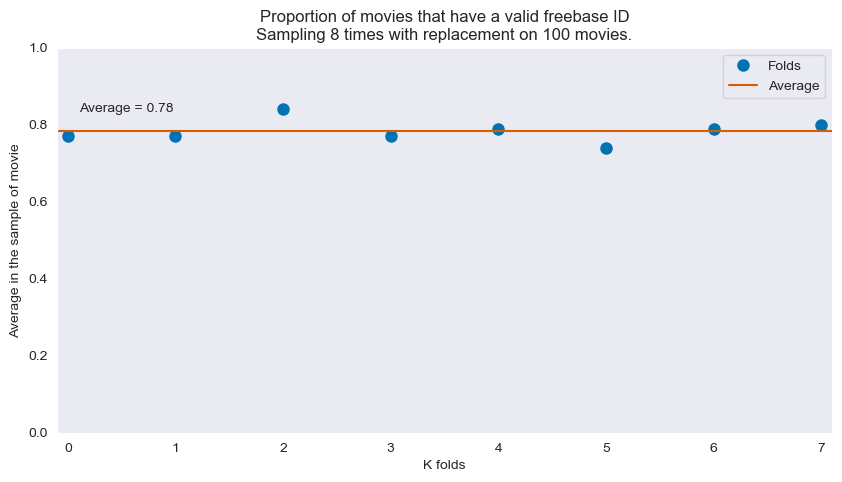

There is around 78.38% of the movies that have an active wikipedia freebase ID.


In [21]:
ratio = [x/n for x in tot]
avg_ratio = sum(ratio)/k_size
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, k_size-1, k_size).astype(int), ratio, marker='o', linewidth=0, markersize=8, color=BLUE, label='Folds')
plt.xticks(np.linspace(0, k_size-1, k_size).astype(int))
plt.plot(np.linspace(-1, k_size, k_size).astype(int), [avg_ratio]*k_size, color=RED, label='Average')
plt.xlim(- 0.1, k_size -1 + 0.1)
plt.ylim(0, 1)
plt.xlabel("K folds")
plt.ylabel("Average in the sample of movie")
plt.grid()
plt.text(0.1, avg_ratio + 0.05, "Average = {:.2f}".format(avg_ratio))
plt.legend()
plt.title("Proportion of movies that have a valid freebase ID\nSampling {} times with replacement on {} movies.".format(k_size, n))
plt.show()
print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(avg_ratio*100))

#### Critical values

In [22]:
#Number of movies with critical values.
nb_critical_values = df_movies[~df_movies.astype(bool).all(axis=1)].shape[0]
print("There are {} rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.".format(nb_critical_values))

There are 17949 rows with critical values. These are values such as: empty dictionaries, 0, nan, etc.


#### Duplicated rows

In [23]:
df_temp = df_movies.copy()
df_temp['m_languages'] = df_temp['m_languages'].apply(lambda x: str(list(x.values())))
df_temp['m_countries'] = df_temp['m_countries'].apply(lambda x: str(list(x.values())))
df_temp['m_genres'] = df_temp['m_genres'].apply(lambda x: str(list(x.values())))
nb_movie_duplicated_rows = df_temp.duplicated().sum()
print("There are {} duplicated rows in the movie dataset.".format(nb_movie_duplicated_rows))

There are 0 duplicated rows in the movie dataset.


#### Duplicated movies

In [24]:
df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)].sort_values('m_name').head(4)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
64872,24604084,/m/080cdj1,A,1998-01-01,NaN,136.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/0gw5n2f': 'Japanese Movies', '/m/03q4nz':..."
66267,23488527,/m/06w8mcl,A,1998-01-01,NaN,NaN,{'/m/09bnf': 'Kannada Language'},{'/m/03rk0': 'India'},{'/m/02l7c8': 'Romance Film'}
38544,33545449,/m/0hgrdzf,A Sister to Assist 'Er,NaT,NaN,59.0,{},{},{'/m/05p553': 'Comedy film'}
74307,33545395,/m/0hgrll0,A Sister to Assist 'Er,NaT,NaN,64.0,{},{},{'/m/05p553': 'Comedy film'}


In [25]:
#Number of duplicated movies.
nb_movies_duplicated = df_movies[df_movies.duplicated(subset=['m_name', 'm_release_date'], keep=False)]['wikipedia_m_ID'].count()
print("There are {} duplicated movies.".format(nb_movies_duplicated))

There are 196 duplicated movies.


#### Movie release date

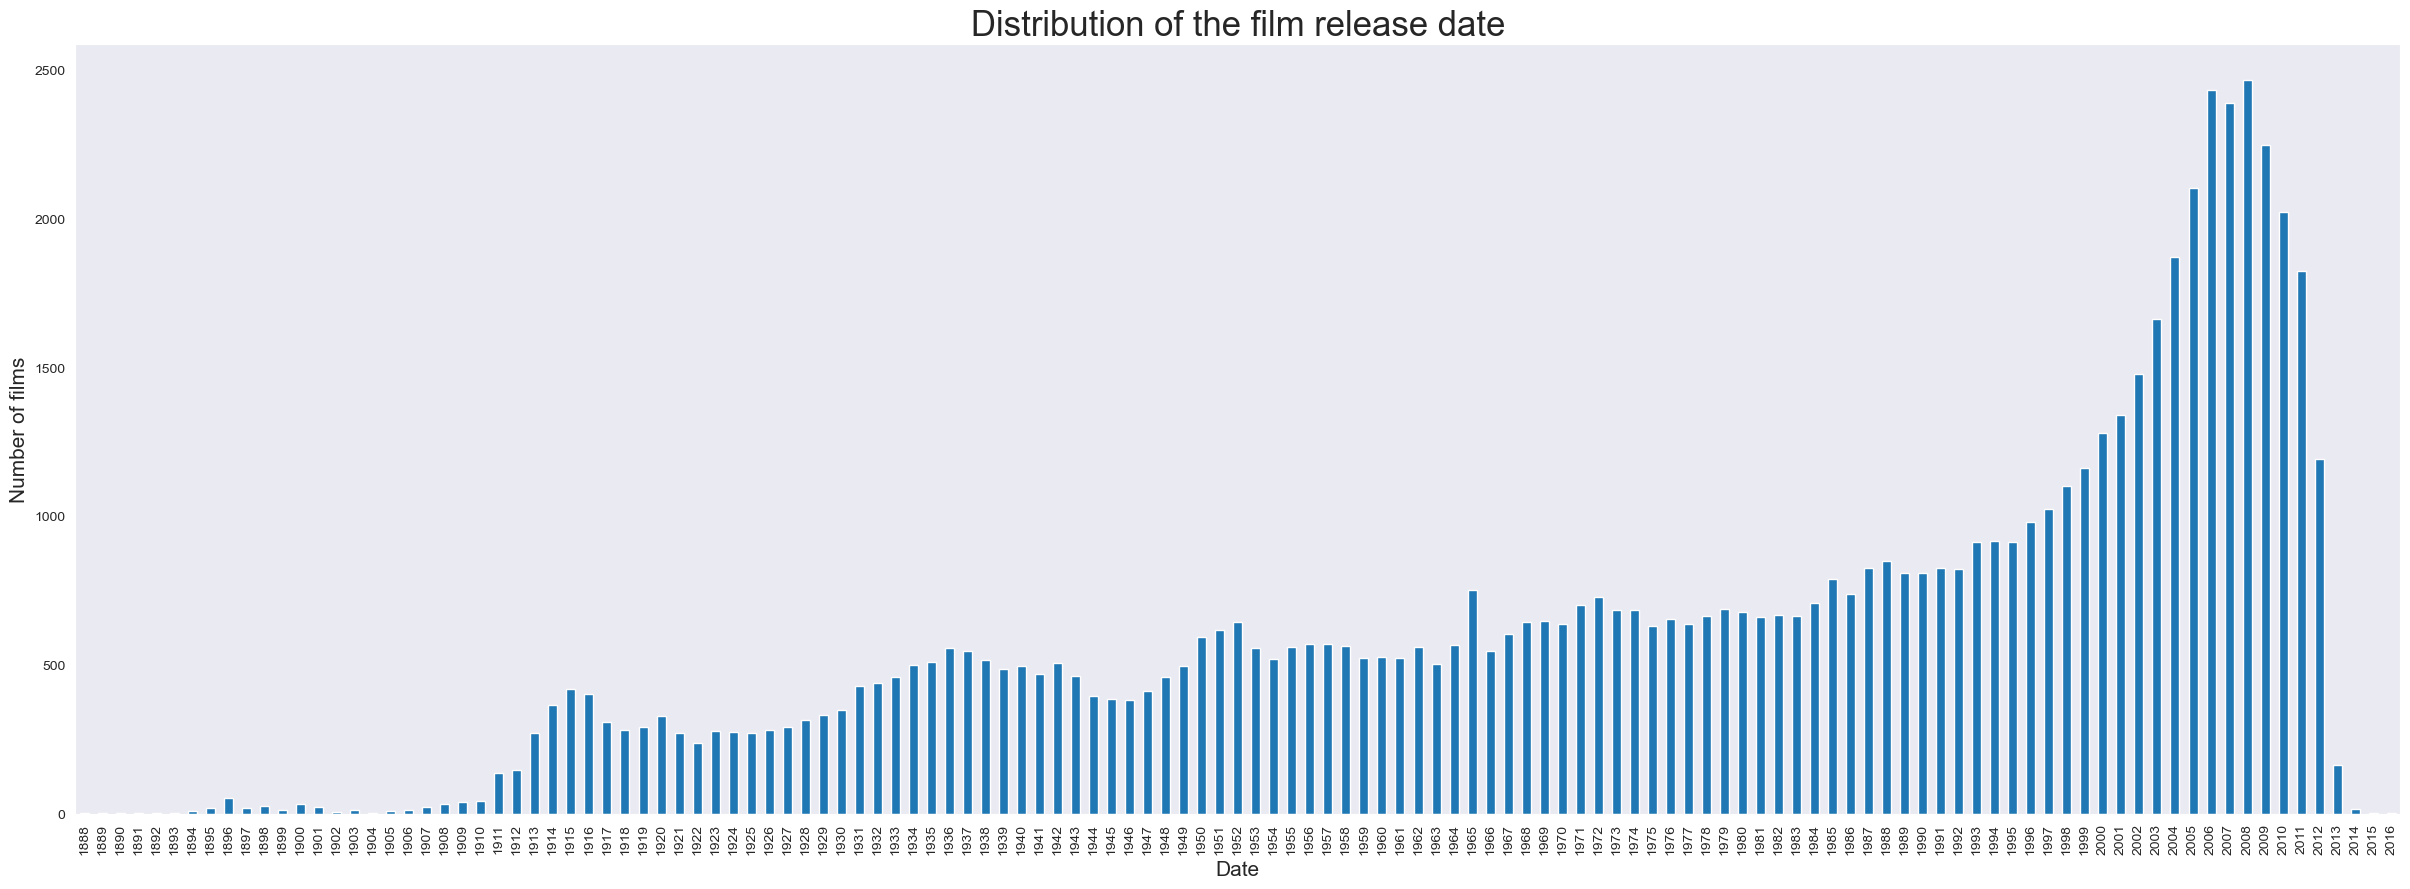

In [26]:
#Movie release date quick overview
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()

In [27]:
#Quick look at the movies after 2013.
df_movies[df_movies['m_release_date'].dt.year > 2013].sort_values('m_release_date', ascending=False).head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
64862,3139382,/m/08tyfg,Battle Angel,2016-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
51429,25813358,/m/0gmbk1g,Avatar 2,2015-01-01,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ..."
53855,32416903,/m/0gys9tc,Total Dhamaal,2015-01-01,NaN,138.0,{'/m/03k50': 'Hindi Language'},{},{'/m/05p553': 'Comedy film'}


In [28]:
nb_movies_after_2013 = df_movies[df_movies['m_release_date'].dt.year > 2013].shape[0]
print("There are {} movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).".format(nb_movies_after_2013))

There are 24 movies released after 2013. It can be seen that several movies have a wrong date of release (e.g Avatar 2).


#### Movie runtime

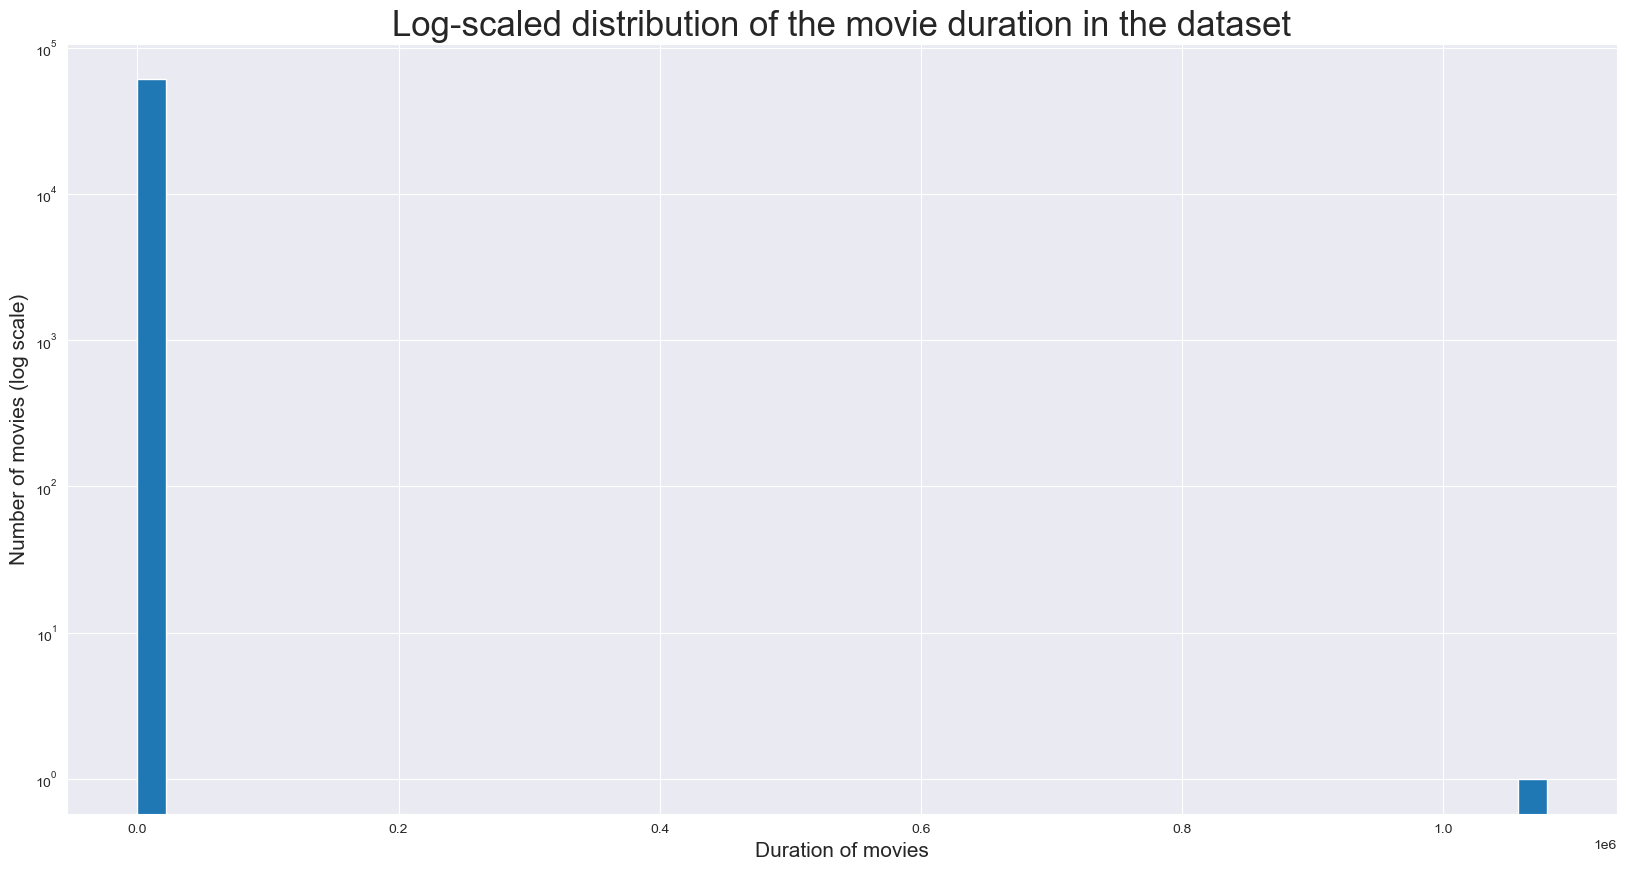

In [29]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [30]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime']>= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime']<= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1.".format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 14 movies which a runtime > 1500 and 107 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

The movie database contains following errors:
- **Critical values**: There are values such as empty dictionaries, 0, False in the rows. For practicity, they'll be all replaced by np.nan values.
- **Duplicated movies**: There are movies that can be considered identical (same movie name and same release date). Some of them are duplicated. They'll be safely removed by keeping the first one as they represent the same movie.
- **Movie release date**: There are some outliers in the movie release date. This mainly concerns movies after 2013. It is due to the creation date of the dataset: 2013. It means all the movies after 2013 are probable dates of release rather than effective ones. Those will be queried using freebase movie ID and changed when possible (as it might be earlier). After this operation, the movies after 2013 will be dropped as it was too recent regarding the dataset creation. This is also a reason why there is too few movies after 2013.
- **Movie runtime**: There are some outliers in the movie runtime. Movie runtime is supposed to be in minutes. However, there is one movie that would last 60 days. In the other way, there are many films that last less than a minute. It is probable that all those cases are due to wrong conversions (i.e duration expressed in seconds or in hours). Those will be queried using freebase movie ID and changed when possible. If the movie does not exist using freebase, the runtime will be kept. But when studying runtime, it will be important to remember those edgecases.

In [31]:
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_release_date'], keep='first')

In [32]:
feature_wiki_ID={
    "runtime": 'AP2047',
    "pubdate":'AP577'
}

def get_freebase_feature_movie(row, value, op, n_lim, feature):
    ops = {
    '>=' : operator.ge,
    '<=' : operator.le,
    '>' : operator.gt,
    '<' : operator.lt,
    }
    op = ops[op]
        
    if feature == 'pubdate':
        val_to_compare=value.year
    else:
        val_to_compare = value
    
    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(feature, id_m, feature_wiki_ID[feature], feature)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            
            if feature == 'runtime':
                new_value = float(response_json[0][feature]['value'])
                if new_value!=value:
                    time.sleep(2)
                    print("{} movie had a {} of {:.2f}. However, using freebase ID, {}={}min.".format(row['m_name'], feature,
                                                                                               value, feature, 
                                                                                               new_value))
                    value = new_value
            elif feature=='pubdate':
                new_value = (response_json[0][feature]['value'])
                new_value=new_value.replace("Z", "")
                new_value = datetime.strptime(new_value,'%Y-%m-%dT%H:%M:%S')
                if new_value.year!=value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature, 
                                                                                               new_value.date()))
                    value = new_value
            
    return value

In [43]:
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

In [34]:
df_movies = df_movies[df_movies.m_release_date.dt.year < 2013]

In [44]:
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature_movie(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.00. However, using freebase ID, runtime=88.0min.
Dhool Ka Phool movie had a runtime of 1533.00. However, using freebase ID, runtime=153.0min.
Cinématon movie had a runtime of 9360.00. However, using freebase ID, runtime=11828.0min.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.00. However, using freebase ID, runtime=148.0min.
As Seen Through a Telescope movie had a runtime of 0.70. However, using freebase ID, runtime=55.0min.
Men Boxing movie had a runtime of 0.08. However, using freebase ID, runtime=5.0min.
Fred Ott's Sneeze movie had a runtime of 0.08. However, using freebase ID, runtime=4.0min.
Sick Kitten movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
The X-Rays movie had a runtime of 0.73. However, using freebase ID, runtime=44.0min.
Blacksmith Scene movie had a runtime of 0.57. However, using freebase ID, runtime=34.0min.
L'Arroseur Arrosé movie had a runtime of 0.82. However, using freebase ID, runtime=

# 4. Dataset preparation
<a class="anchor" id="datapreparation"></a>

### 4.1 Characters dataset
<a class="anchor" id="datapreparation_characters"></a>

The ethnicity of each actor is mapped using a wikidata freebase query.

In [45]:
dict_ethnicities = {}
def map_ethnicities(arr_ethn):
    for x in arr_ethn[1:]:
        time.sleep(1)
        x = x.split('/')[2]
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(x)
        response_json = requests.get(query).json()['results']['bindings']
        if len(response_json):
            value = response_json[0]['sLabel']['value']
            dict_ethnicities.update({'/m/'+x: value})

def save_ethnicities():
    csv_columns = ['freebase_ID', 'value']
    with open(ETHNICITIES_PATH, 'w', encoding="utf-8") as f:
        writer_object = csv.writer(f)
        for key in dict_ethnicities.keys():
            value = dict_ethnicities[key]
            writer_object.writerow([key, value])
        f.close()
    return

def get_ethnicities():
    ethnicities = {}
    with open(ETHNICITIES_PATH, 'r', encoding="utf-8") as f:
        reader_object = csv.reader(f)
        for data in reader_object:
            if data:
                key, value = data
                ethnicities.update({key:value})
    return ethnicities

In [ ]:
#map_ethnicities(df_chars['actor_ethnicity'].dropna().unique())
#save_ethnicities(dict_ethnicities)

In [ ]:
ethnicities = get_ethnicities()

In [ ]:
df_chars['actor_ethnicity'] = df_chars['actor_ethnicity'].apply(lambda x: ethnicities[x] if x in ethnicities.keys() else np.nan)

### 4.2 Actors dataset
<a class="anchor" id="datapreparation_actors"></a>

Unique actors will be computed using the unique features (actor_name, actor_dob), as it is what will be used to map the actors to a popularity database. They will be saved in df_actors.

In [ ]:
df_actors = df_chars.drop_duplicates(subset=['actor_dob', 'actor_name'], keep='first')

### 4.3 Movie dataset
<a class="anchor" id="datapreparation_movies"></a>

3 columns of the movie dataset will be split: movie languages, movie country of production and movie genres. They will be split in two columns: freebase ID in the first, and value in the other.

In [36]:
def split_feature(row, feature, flag):
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [37]:
features=['m_languages', 'm_countries', 'm_genres']
_freebase_ID='_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID]=df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature]=df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

# 5. Data exploration
<a class="anchor" id="dataexploration"></a>

In [ ]:
nb_actors = df_actors['actor_name'].count()
nb_actors_freebase_id = df_chars['freebase_actor_id'].drop_duplicates().count()
print("There are {} actors with different (name, date of birth) in the dataset. However, there are {} different actor freebase ID.".format(nb_actors, nb_actors_freebase_id))

The difference between the two figures is due to some incorrect matching (actor --> actor freebase ID). Those won't be taken into account when analysing "unique actors".

### 5.1 Characters and actors analysis
<a class="anchor" id="dataexploration_characters"></a>

In [ ]:
nb_chars = df_chars['wikipedia_m_ID'].count()
nb_chars_with_freebase = df_chars['freebase_character_id'].count()
print("There are {} characters and only {:.2f}% of them has a known freebase character ID.".format(nb_chars, nb_chars_with_freebase/nb_chars*100))

In [ ]:
# Plots distribution of characters per movie
plt.figure(figsize=(10,6))
plt.title('Distribution of the number of characters per film in log scale')
plt.xlabel('Number of characters (in the DB) per film')
plt.ylabel('Count in log scale')
plt.hist(df_chars['wikipedia_m_ID'].value_counts(), log=True, bins=80, color=BLUE)
plt.tight_layout()
plt.grid()
plt.show()

### Casting age

In [ ]:
nb_chars_with_age = df_chars['actor_age'].value_counts().sum()
print("There are {} characters whose actor has a known age at the time he·she played the movie, which represents {:.2f}% of the characters.".format(nb_chars_with_age, nb_chars_with_age/nb_chars*100))

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(df_chars[df_chars.actor_gender == 'M'].actor_age, color=PURPLE, kde=True, label="Men")
sns.histplot(df_chars[df_chars.actor_gender == 'F'].actor_age, color=ORANGE, kde=True, label="Women")
plt.title("Casting age distribution", fontsize=25)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend()
plt.show()

### Casting gender

In [ ]:
nb_chars_with_gender = df_chars['actor_gender'].value_counts().sum()
print("There are {} characters whose actor has a known gender at the time he·she played the movie, which represents {:.2f}% of the characters.".format(nb_chars_with_gender, nb_chars_with_gender/nb_chars*100))

In [ ]:
plt.title('Casting gender distribution')
plt.title('Gender distribution of the casting in the dataset')
plt.pie(df_chars['actor_gender'].value_counts(), labels=['Men', 'Women'], autopct='%.0f%%', colors=[PURPLE, ORANGE])
plt.tight_layout()
plt.show()

### Actors gender

In [ ]:
nb_actors_with_gender = df_actors['actor_gender'].value_counts().sum()
print("There are {} actors with a known gender, which represents {:.2f}% of the actors.".format(nb_actors_with_gender, nb_actors_with_gender/nb_actors*100))

In [ ]:
# Distribution of actors by gender
plt.title('Gender distribution of the actors in the dataset')
plt.pie(df_actors['actor_gender'].value_counts(), labels=['Men', 'Women'], autopct='%.0f%%', colors=[PURPLE, ORANGE])
plt.show()

There seem to be a different mean between both distributions (actors and casting genders). A T-test will be performed to know whether the mean is significatively different. As it is a binary column (Male or Female), binary values were attributed (0 for Male and 1 for Female).

In [ ]:
stats.ttest_ind(df_chars.actor_gender.dropna().apply(lambda x: 1 if x=='F' else 0), df_actors.actor_gender.dropna().apply(lambda x: 1 if x=='F' else 0))

The p-value of the t-test being really close to 0, there is a significant difference in the distribution. The value of the t-test being largely negative (-15.6), it means that there are significally less women in average in the casting than in the actors. It means that women are less represented in movies than men, regardless of the initial proportion of women and men in the actor set.

### Actors birthdate

In [ ]:
df_actors['actor_dob'].value_counts(dropna=False)

In [ ]:
nb_actors_with_dob = df_actors['actor_dob'].count()
print("There are {} actors with a known birth date, which represents {:.2f}% of the actors.".format(nb_actors_with_dob, nb_actors_with_dob/nb_actors*100))

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(df_actors[df_actors.actor_gender == 'M'].actor_dob, color=PURPLE, kde=True, label="Men")
sns.histplot(df_actors[df_actors.actor_gender == 'F'].actor_dob, color=ORANGE, kde=True, label="Women")
plt.title("Birth date distribution of the actors")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.show()

### Character ethnicity

In [ ]:
plt.figure(figsize=(20, 6))
nb = 15
df_chars['actor_ethnicity'].value_counts()[:nb].plot(kind='bar', color=BLUE)
plt.ylabel("Count")
plt.xlabel("Cast ethnicity")
plt.title("Distribution of the cast {} main ethnicities".format(nb))
plt.show()

### Actor ethnicity

In [ ]:
nb_actors_with_ethnicity = df_actors['actor_ethnicity'].value_counts().sum()
print("There are {} actors with a known ethnicity, which represents {:.2f}% of the actors.".format(nb_actors_with_ethnicity, nb_actors_with_ethnicity/nb_actors*100))

In [ ]:
plt.figure(figsize=(20, 6))
df_actors['actor_ethnicity'].value_counts()[:30].plot(kind='bar', color=BLUE)
plt.ylabel("Count")
plt.xlabel("Actor ethnicity")
plt.title("Distribution of the actors ethnicity")
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
nb = 15
X_axis = np.linspace(0, nb, nb)
plt.bar(X_axis - 0.2, (df_actors['actor_ethnicity'].value_counts()[:nb]/df_actors['actor_ethnicity'].count()).values, 0.4, label = 'Actors', color=BLUE)
plt.bar(X_axis + 0.2, (df_chars['actor_ethnicity'].value_counts()[df_actors['actor_ethnicity'].value_counts()[:nb].index]/df_chars['actor_ethnicity'].count()).values, 0.4, label = 'Casting', color=RED)

plt.xticks(X_axis, df_actors['actor_ethnicity'].value_counts()[:nb].index, rotation=90)
plt.ylabel("Proportion")
plt.xlabel("Ethnicity")
plt.title("Proportion of the actors vs casting {} main ethnicities in the dataset".format(nb))
plt.legend()
plt.show()

As shown in the graph above, there seem to be a difference in the distribution of the African Americans and Indians ethnicities, regarding actors and casting. It will be confirmed or infirmed using a t-test.

In [ ]:
stats.ttest_ind(df_actors['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'African Americans' else 0), df_chars['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'African Americans' else 0))

In [ ]:
stats.ttest_ind(df_actors['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'Indians' else 0), df_chars['actor_ethnicity'].dropna().apply(lambda x: 1 if x == 'Indians' else 0))

It could be deduced that African Americans actors play in average less in movies than Indian actors. However, there is less than 20% of the actors with a known ethnicity. It that way, there is too few data to conclude anything as there are too many actors for which the ethnicity is unknown.

For the following, actor ethnicity won't be taken into account when studying actor relationship as there is too few data available.

### Actors role distribution

In [ ]:
cnt_m = df_chars[df_chars.actor_gender == "M"].groupby(['actor_name', 'actor_dob']).nunique().sort_values('wikipedia_m_ID', ascending=False)[['wikipedia_m_ID', 'character_name']].reset_index()
cnt_w = df_chars[df_chars.actor_gender == "F"].groupby(['actor_name', 'actor_dob']).nunique().sort_values('wikipedia_m_ID', ascending=False)[['wikipedia_m_ID', 'character_name']].reset_index()

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(cnt_m['wikipedia_m_ID'], log_scale=(False, True), bins=50, color=PURPLE, label="Men")
sns.histplot(cnt_w['wikipedia_m_ID'], log_scale=(False, True), bins=50, color=ORANGE, label="Women")
plt.xlabel("Number of film played in")
plt.title("Number of roles distribution (in log scale)")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

As we can see, there is quite some disparity in the dataset between the number of movies and characters for a single actor. This is explained for some actors like Dharmendra Deol by having a lot of null values in the character name column (maybe due to bad char encoding choice). For others like Mel Blanc, (who was a voice actor) this is explained by having played some characters in different films like Buggs Bunny for example. Also, as he only was a voice actor, he is mentionned many times for the same film.

### Time between first and last performance

In [ ]:
# carreer length distribution
carreers = df_chars[['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_age']].groupby('actor_name', dropna=False).agg({'actor_age': ['mean', 'min', 'max', 'count'], 'actor_gender': ['first']}).reset_index()
carreers['duration'] = carreers.actor_age['max'] - carreers.actor_age['min']

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(carreers[carreers.actor_gender['first'] == "M"]['duration'], log_scale=(False, True), color=PURPLE, label="Men")
sns.histplot(carreers[carreers.actor_gender['first'] == "F"]['duration'], log_scale=(False, True), color=ORANGE, label="Women")
plt.xlabel("Career length in years")
plt.title("Career length distribution")
plt.legend()
plt.show()

### Age distribution for first and last movie

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(x=carreers.actor_gender['first'], y=carreers.actor_age["min"], ax=axs[0], palette=[PURPLE, ORANGE])
sns.boxplot(x=carreers.actor_gender['first'], y=carreers.actor_age["max"], ax=axs[1], palette=[PURPLE, ORANGE])
axs[0].set_xlabel("Actor gender")
axs[1].set_xlabel("Actor gender")
axs[0].set_ylabel("Age at first movie")
axs[1].set_ylabel("Age at last movie")
plt.tight_layout()
plt.show()

### Interaction between actors

In [ ]:
# let's start in a subset first : year [1980, 1990)
date1 = datetime(1980, 1, 1)
date2 = datetime(1984, 12, 31)

selected_years = df_chars[df_chars.m_release_date.between(date1, date2)]

In [ ]:
binom = pd.DataFrame()
# try and binomial
for elem in selected_years.wikipedia_m_ID.unique()[:1000]:
    tmp = selected_years[selected_years.wikipedia_m_ID == elem]
    tmp = pd.merge(tmp, tmp, 'cross', suffixes=("1","2"))
    tmp = tmp[tmp.actor_name1 > tmp.actor_name2]
    binom = pd.concat([binom, tmp])

In [ ]:
binom = binom[['actor_name1', 'actor_name2', 'wikipedia_m_ID1']]

In [ ]:
binom.shape

In [ ]:
binom['weight'] = 1

In [ ]:
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(binom, 'actor_name1', 'actor_name2')
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

The above graph shows the relations between acotrs, as defined in *node degree distribution*. As we can see, the graph isn't fully connected. This makes sense, given that a large amount of actors only played in a single or a couple of films. To have a better idea of what is happening, let's plot the giant connected component (GCC).

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[0])
nx.draw(GCC, pos=nx.kamada_kawai_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[1])
axs[0].set_xlabel("Spring")
axs[1].set_xlabel("Kamada-Kawai")
plt.title("Giant connected components of co-acting interactions graph")
plt.show()

Even though we observe a pretty dense graph, it doesn't tell us much, as there is too much data to clearly see what is happening. We can however easily compute the edge to node ratio to get the average degree of a node. This roughly corresponds to the number of films an actor starred in divided by the average number of actors per film.

In [ ]:
print('The edge to node ratio of the graph is {.03f}'.format(G.number_of_nodes/G.number_of_edges))

### 5.2 Movie general analysis
<a class="anchor" id="dataexploration_movies"></a>

### Movie name

In [ ]:
nb_movies = df_movies[["m_name", "freebase_m_ID"]].value_counts().count()
unique_wikipedia_m_id = df_movies["wikipedia_m_ID"].count()
print("There are {} different movies, corresponding to {} different wikipedia ID.".format(nb_movies, 
                                                                                          unique_wikipedia_m_id))

In [ ]:
nb_duplicated_titles = df_movies[df_movies.duplicated('m_name', keep=False)]['wikipedia_m_ID'].count()
print("There are {} movies with duplicated titles.".format(nb_duplicated_titles))

In [ ]:
df_movies["m_name"].value_counts()

One can see that when some movies have the same title, it mainly corresponds to either remake movies or common titles where movies have nothing in common.

### Movie release date

In [ ]:
nb_movies_with_release_date = df_movies['m_release_date'].dropna().count()
print("There are {} movies with a known release date. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_release_date, nb_movies_with_release_date / nb_movies * 100))

Histogram of release date

In [ ]:
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()

### Movie box office

In [ ]:
nb_movies_with_BO = df_movies['m_BO_revenue'].dropna().count()
print("There are {} movies with a known box office revenue. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_BO, nb_movies_with_BO / nb_movies * 100))

Histogram of box office

In [ ]:
df_movies.groupby(df_movies.m_release_date.dt.year).mean()['m_BO_revenue'].dropna().plot(figsize=(20,6), color=BLUE)
plt.grid()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average box office revenue', fontsize=15)
plt.title('Average box office revenue of movies per year', fontsize=25)
plt.show()

### Movie runtime

In [ ]:
nb_movies_with_runtime = df_movies['m_runtime'].dropna().count()
print("There are {} movies with a known runtime duration. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_runtime, nb_movies_with_runtime / nb_movies * 100))

Histogram of the runtime

In [ ]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies (min)', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

The average duration of a movie throughout the years is now studied. A bootstrap version is computed. 

In [40]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [41]:
merge = df_movies.m_release_date.dt.year

stat = df_movies[df_movies['m_runtime']<5000][['m_release_date', 'm_runtime']].dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_runtime': x['m_runtime'].mean(),
    'lower_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[0],
    'upper_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[1]
}))

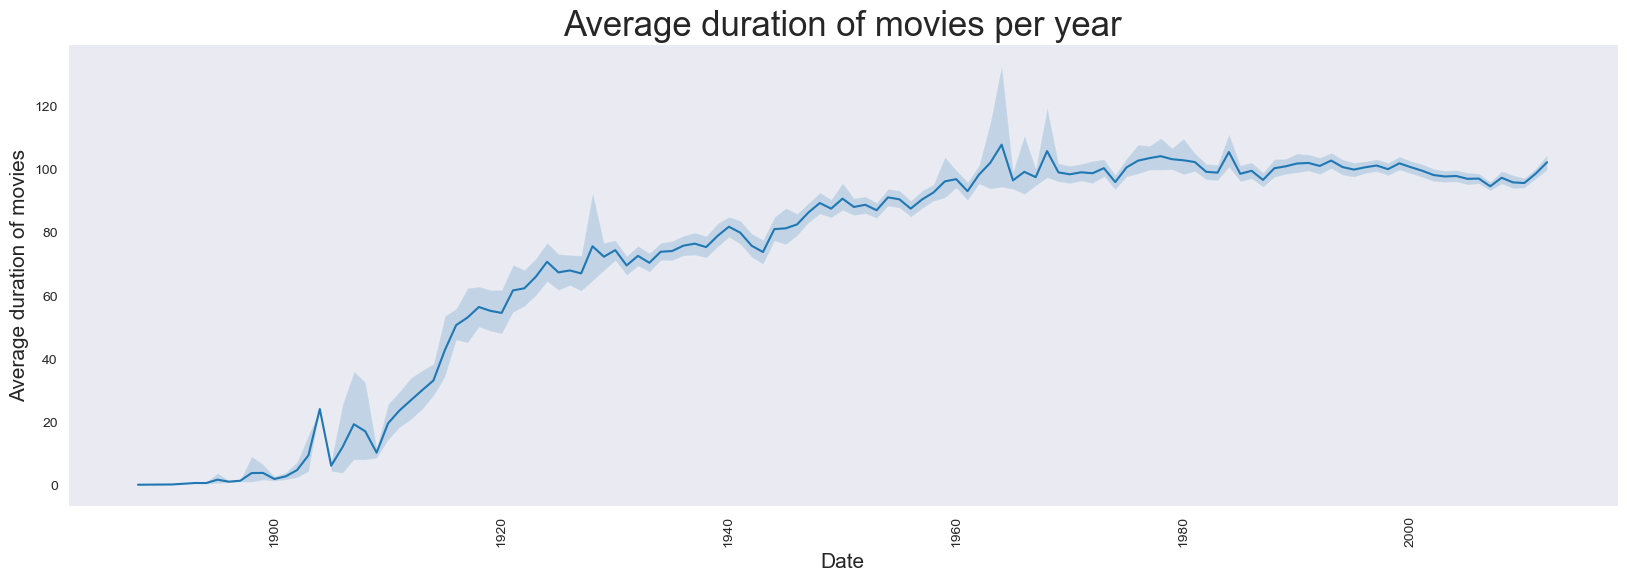

In [42]:
plt.figure(figsize=(20,6))

plt.fill_between(stat.index, stat.lower_err_runtime, stat.upper_err_runtime, alpha=0.2)
plt.plot(stat.average_runtime)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Average duration of movies', fontsize=15)
plt.title('Average duration of movies per year', fontsize=25)
plt.show()

### Movie genres

In [ ]:
df_genres_m = df_movies.explode('m_genres').dropna(subset='m_genres')
df_genres_m['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [ ]:
#df_genre_merged_m = df_genres_m.merge(df_movies, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
plt.figure(figsize=(20,6))
df_genres_m[["m_BO_revenue", "m_genres"]].dropna().groupby('m_genres')['m_BO_revenue'].mean().sort_values(ascending=False)[:30].plot(kind='bar')
plt.title('Box Office revenue per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Box Office revenue', fontsize = 15)
plt.show()

In [ ]:
merge = 'm_genres'

stat = df_genres_m.dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(10,5))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_genres_m.dropna(subset='m_BO_revenue')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Movie genre', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e8)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per genre', fontsize=25)
plt.show()

In [ ]:
df_genre_a= df_genres_m.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

In [ ]:
merge = ['m_genres']

df_temp = df_genre_a[['wikipedia_m_ID', 'm_genres', 'actor_gender']].copy()

df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)

stat = df_temp.dropna(subset=['actor_gender', 'm_genres']).groupby(['m_genres', 'wikipedia_m_ID']).mean().groupby(merge).apply(lambda x: pd.Series({
    'average_gender': x['actor_gender'].mean(),
    'lower_err_gender': bootstrap_CI(x['actor_gender'], 1000)[0],
    'upper_err_gender': bootstrap_CI(x['actor_gender'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[:30]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[:30],
         yerr = [-stat.lower_err_gender[:30] + stat.average_gender[:30], 
                -stat.average_gender[:30] + stat.upper_err_gender[:30]],
         capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the most represented per movie', fontsize=25)
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[-30:]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[-30:],
             yerr = [-stat.lower_err_gender[-30:] + stat.average_gender[-30:],
                     -stat.average_gender[-30:] + stat.upper_err_gender[-30:]],
             capsize= 3)

plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.xlabel('Genre (number of movies)', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the least represented per movie', fontsize=25)
plt.show()

### Country of production

In [ ]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

Check to know if there were two identical country of production for a same movie.

In [ ]:
df_countries_m[df_countries_m.duplicated(['m_countries', 'wikipedia_m_ID'], keep=False)]

In [ ]:
df_countries_m['m_countries'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per country of production', fontsize = 25)
plt.xlabel('Movie country of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [ ]:
nb_movies_with_countries = df_countries_m.dropna(subset='m_countries')['wikipedia_m_ID'].nunique()
print("There are {} movies with a known country of production. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_countries, nb_movies_with_countries / nb_movies * 100))

In [ ]:
merge = 'm_countries'

stat = df_countries_m.dropna(subset=['m_BO_revenue', 'm_countries']).groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Country of production', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e6)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per country of production', fontsize=25)
plt.show()

In [ ]:
nb_value_BO_USA = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()['United States of America']
print("American movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_USA/nb_movies_with_BO *100))

### Movie languages

In [ ]:
df_languages_m = df_movies.explode('m_languages').dropna(subset='m_languages')
nb_unique_languages = df_languages_m['m_languages'].nunique()
print("There are {} different languages present in the dataset.".format(nb_unique_languages))

Check to know if there were two identical languages of production for a same movie.

In [ ]:
df_languages_m[df_languages_m.duplicated(['m_languages', 'wikipedia_m_ID'], keep=False)]

In [ ]:
df_languages_m['m_languages'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per language of production', fontsize = 25)
plt.xlabel('Movie language of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [ ]:
nb_value_BO_english = df_languages_m.dropna(subset='m_BO_revenue')['m_languages'].value_counts()['English Language']
print("English language movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_english/nb_movies_with_BO *100))

# Zoom on American movies

In [ ]:
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']
df_m_a = df_movies_USA.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')

In [ ]:
df_movies_USA.describe()

### Movie genres

In [ ]:
df_genres_m_USA = df_movies_USA.explode('m_genres')

In [ ]:
nb_genres_USA = df_genres_m_USA['m_genres'].nunique()
print("There are {} different genre in american movies.".format(nb_genres_USA))

In [ ]:
plt.figure(figsize=(20,6))
df_genres_m_USA['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [ ]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns

In [ ]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

In [ ]:
n=nb_genres_USA
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
#pca.fit_transform(df_USA_genres_one_hot)
pca.fit(X_features)
pca_variance = pca.explained_variance_
pca_variance_ratio = pca.explained_variance_ratio_

csum = np.cumsum(pca_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(csum)
plt.plot(15, 0.6, marker='o', color='red') 
plt.ylabel('Variance ratio')
plt.xlabel('Number of component')
plt.title('Culumated variance ratio vs number of components')
plt.text(15, 0.6, '  ({}, {})'.format(15, 0.6))
plt.show()

It was decided to keep 15 features in order to get 60% of the cumulated variance.

In [ ]:
n=15
scaler = StandardScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
best_four_important = []
most_important_names = []
n_best = 4
initial_feature_names = genres_one_hot_labels
for i in range(n_pcs):
    elts = np.argsort((pca.components_[i]))[::-1][:n_best]
    best_four_important.append(elts)
    most_important_names.append([initial_feature_names[elts[i]] for i in range(n_best)])

In [ ]:
new_space = pca.transform(df_USA_genres_one_hot.values)
new_space = new_space.argmax(axis=1)
df_USA_genres_one_hot['m_genre_PCA'] = new_space
df_USA_genres_one_hot['m_genre_PCA'] = df_USA_genres_one_hot['m_genre_PCA'].apply(lambda x: ", ".join(most_important_names[x]))

In [ ]:
df_movies_USA_genre_PCA = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
df_movies_USA_genre_PCA.head()

In [ ]:
nb_movies_USA_with_genre = df_genres_m_USA.dropna(subset='m_genres')['wikipedia_m_ID'].nunique()
output = []
for pc in most_important_names:
    for x in pc:
        if x not in output:
            output.append(x)
nb_USA_genres_reduced = df_genres_m_USA[df_genres_m_USA['m_genres'].isin(output)]['wikipedia_m_ID'].nunique()
print("Selecting n={} genres out of {} different genres in american movies, the new dataset consists of {} american movies, which represent {:.2f}% of american movies with a known genre.".format(len(output), nb_genres_USA, nb_USA_genres_reduced, nb_USA_genres_reduced/nb_movies_USA_with_genre*100))

In [ ]:
plt.figure(figsize=(20,6))
df_movies_USA_genre_PCA['m_genre_PCA'].value_counts().plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre after PCA', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

### Actor representation

In [ ]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)
    print(data)
    print(len(data))

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [ ]:
df_temp.reset_index()

In [ ]:
merge = ['wikipedia_m_ID']


#distrib = [df_m_a, df_countries_m.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')]
distrib = [df_m_a]
stats_comparison = []

for df in distrib:
    df_temp = df[['actor_gender', 'wikipedia_m_ID']].copy()
    df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)
    df_temp = df_temp.dropna(subset=['actor_gender']).groupby(merge).mean().reset_index()
    print("temp", df_temp)
    stat = df_temp.apply(lambda x: pd.Series({
        'average_gender': x['actor_gender'].mean(),
        'lower_err_gender': bootstrap_CI(x['actor_gender'], 1)[0],
        'upper_err_gender': bootstrap_CI(x['actor_gender'], 1)[1]
    }), axis=1)
    stats_comparison.append(stat)

print(stats_comparison[0])

plt.figure(figsize=(20,6))
for stat in stats_comparison:
    print(stat.index)
    labels = stat.index

    plt.errorbar(labels, stat.average_gender,
             yerr = [-stat.lower_err_gender + stat.average_gender,
                    -stat.average_gender + stat.upper_err_gender],
             capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Distribution of the proportion of women in the american movies', fontsize=25)
plt.show()

### Title

In [ ]:
temp_df = df_movies_USA.merge(df_USA_genres_one_hot[['m_genre_PCA']], left_on='wikipedia_m_ID', right_on='wikipedia_m_ID').drop(columns=['m_BO_revenue', 'm_runtime', 'm_languages', 'm_countries', 'm_genres', 'm_languages_freebase_ID', 'm_countries_freebase_ID', 'm_genres_freebase_ID'])

big_df = pd.merge(temp_df, df_actors, left_on=['wikipedia_m_ID', 'freebase_m_ID' , 'm_release_date'], right_on=['wikipedia_m_ID', 'freebase_m_ID' , 'm_release_date'])
big_df = big_df.drop(columns=['freebase_m_ID', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_age', 'freebase_character_id', 'freebase_character_map', 'freebase_actor_id'])

big_df

In [ ]:
action_actors = big_df
genre_dict = {}
for vec in action_actors.m_genre_PCA.drop_duplicates():
    genre_dict[vec] = action_actors[action_actors['m_genre_PCA'] == vec]

test_graph = genre_dict[", ".join(most_important_names[0])]

graph = pd.merge(test_graph, test_graph, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
graph.head()

In [ ]:
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')

In [ ]:
nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)

As we can see, not all actors in this category are connected, let's see how the GCC looks like.

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

In [ ]:
nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1)

The above graph shows the GCC for all the actors that have played in the 1000 first films. We used 2 different layouts, that both can highlight different graph properties. We can see on graph using the spring layout that there is a strongly connected component, and some outliers. The Kamada-Kawai additionnaly shows that there are a few hubs, i.e. nodes that connect the strongly connected to some outliers.

### Node degree distribution
In graph theory, the degree of a node is the number of edges reaching a node. In our example, nodes are actors, and edges between nodes are movies in which both actors played. An important note is that not all actors are listed in our database, an average of 5 characters (hence actors) per movie are listed. Thus, the node degree of an actor is the number of films they played with another actor, according to our database.

In [ ]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
sns.histplot(degree_sequence, bins=50, log_scale = (False, True))
plt.title("Example of node degree distribution \nwith genre {} in log scale".format(most_important_names[0]))
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
sns.histplot(degree_sequence, bins=50, log_scale = (False, True), ax=axs[0])
plt.title("Example of node degree distribution \nwith genre {} in log scale".format(most_important_names[0]))

t_graph = pd.merge(big_df, big_df, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
t_graph = t_graph[t_graph.actor_name_x < t_graph.actor_name_y]

G = nx.from_pandas_edgelist(t_graph, 'actor_name_x', 'actor_name_y')
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
sns.histplot(degree_sequence, bins=50, log=True, ax=axs[1])
plt.title("Node degree distribution")


plt.show()

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(20, 9), sharey='all', sharex='all')

i = 0
for k in genre_dict:
    ax= axs[int(i/3)][i%3]
    graph = pd.merge(genre_dict[k], genre_dict[k], on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
    graph = graph[graph.actor_name_x < graph.actor_name_y]
    g = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
    largest_cc = max(nx.connected_components(G), key=len)
    gcc = g.subgraph(largest_cc)

    degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    gcc_degree_sequence = sorted((d for n, d in gcc.degree()), reverse=True)

    sns.histplot(degree_sequence, bins=50, log=True, ax=ax, label='Whole graph')
    sns.histplot(gcc_degree_sequence, bins=50, log=True, ax=ax, label='GCC')
    ax.set_title(k)
    ax.set_xlabel("degree")
    i+=1

plt.suptitle("Node degree distribution by genre")
plt.tight_layout()
plt.show()

### Graph connectivity


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9), sharey='all', sharex='all')

graph = pd.merge(genre_dict[0], genre_dict[0], on=['wikipedia_m_ID', 'm_release_date', 'm_name', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[0])
nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[1])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9), sharey='all', sharex='all')

graph = pd.merge(genre_dict[11], genre_dict[11], on=['wikipedia_m_ID', 'm_release_date', 'm_name', 'm_genre_PCA'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
# graph with interactions between actors. not very interesting, even when plotting only the GCC
G = nx.from_pandas_edgelist(graph, 'actor_name_x', 'actor_name_y')
largest_cc = max(nx.connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[0])
nx.draw(GCC, pos=nx.spring_layout(GCC), node_size=10, node_color=[(0., .8, 1, 0.24)] ,width=.1, ax=axs[1])

### Actors intersection between genres

In [ ]:
plt.figure(figsize=(12, 8))
intersection_log = np.empty((15, 15))
intersection = np.empty((15, 15))
actors = []
heatmap_labels = []

for k in genre_dict:
    actor_set = set(genre_dict[k]['actor_name'])
    actors.append([k, len(actor_set), actor_set])
    heatmap_labels.append(k[:30]+"...")

actors.sort(key=lambda x: x[1], reverse=True)

for i, genre1 in enumerate(actors):
    for j, genre2 in enumerate(actors):
        intersection[i][j] = len(genre1[2].intersection(genre2[2]))/len(genre1[2].union(genre2[2]))


sns.heatmap(intersection,  annot=True, yticklabels=heatmap_labels, xticklabels=heatmap_labels)

plt.title('Set intersection cardinality between genres')
plt.tight_layout()
plt.show()

In [ ]:
# find distribution for 1st film, second film, ... per actor
test = big_df.sort_values(['actor_name', 'm_release_date']).reset_index()[['m_genre_PCA', 'actor_name']]
test['number'] = 0
test.dropna(subset='actor_name', axis=0, inplace=True)
prev_actor = ""
i = 0
test = test[test.actor_name != 'Mel Blanc']
for idx, row in test.iterrows():
    if row.actor_name != prev_actor:
        prev_actor = row.actor_name
        i = 0
    i+=1
    test.at[idx, 'number'] = i

In [ ]:
stacked_df = pd.DataFrame()
for group in test.groupby('m_genre_PCA'):
    tmp = group[1].groupby('number').count()['actor_name']
    tmp = tmp.reindex(list(range(1,tmp.index.max()+1)), fill_value=0)
    stacked_df[group[0]] = tmp

stacked_df = stacked_df.fillna(0)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
stacked_df.head(50).plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Genre evolution in carreer length')
axs[0].set_xlabel('nth film for actor')
axs[0].set_ylabel('count of roles in film genres')
norm_stacked = stacked_df.copy()
norm_stacked = norm_stacked.apply(lambda row: row/row.sum(), axis=1)

norm_stacked.head(50).plot(kind='bar', stacked=True, ax=axs[1], legend=False)
axs[1].set_title('Genre evolution in carreer length, normalized')
axs[0].set_xlabel('nth film for actor')
axs[0].set_ylabel('% of roles in film genres')

plt.show()

### Evolution of genre. "Cumulative bar plots"?

Take actors born at the same period ? or actors that have high vs low popularity ? how to represent data ?

# Trials de merde

In [ ]:
df_stats = df_m_metadata.dropna()
stats.pearsonr(df_stats['m_runtime'],df_stats['m_BO_revenue'])

In [ ]:
stats.spearmanr(df_stats['m_runtime'],df_stats['m_BO_revenue'])

In [ ]:
stats.pearsonr(df_stats['m_release_date'].dt.year, df_stats['m_BO_revenue'])

In [ ]:
stats.spearmanr(df_stats['m_release_date'].dt.year, df_stats['m_BO_revenue'])

In [ ]:
df_countries_merged= df_countries_exploded.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

In [ ]:
american_actors = df_countries_merged[df_countries_merged["m_countries"] == 'United States of America']

In [ ]:
american_actors.groupby("actor_name")["wikipedia_movie_id"].count().sort_values(ascending=False)[:1000]

In [ ]:
df_genre_merged= df_genre_exploded.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

In [ ]:
df_genre_merged.head()

In [ ]:
#df_genre_merged['m_genre_hash'] = df_genre_merged['m_genres'].apply(lambda x: hash(x))
#df_genre_merged['actor_gender_hash'] = df_genre_merged['actor_gender'].apply(lambda x: hash(x))
#df_genre_merged['actor_ethnicity_hash'] = df_genre_merged['actor_ethnicity'].apply(lambda x: hash(x))

In [ ]:
stats.pearsonr(df_genre_merged['movie_release_date'].dt.year, df_genre_merged['m_genre_hash'])

In [ ]:
#stats.pearsonr(df_genre_merged['actor_gender_hash'], df_genre_merged['m_genre_hash'])

In [ ]:
#stats.pearsonr(df_genre_merged['actor_ethnicity_hash'], df_genre_merged['m_genre_hash'])

In [ ]:
df_corr=df_genre_merged.copy()
df_corr['actor_gender']=df_corr['actor_gender'].astype('category').cat.codes
df_corr['m_genres']=df_corr['m_genres'].astype('category').cat.codes
df_corr['actor_dob']=df_corr['actor_dob'].dt.year.astype('category').cat.codes
df_corr['actor_ethnicity']=df_corr['actor_ethnicity'].astype('category').cat.codes
df_corr['movie_release_date']=df_corr['movie_release_date'].astype('category').cat.codes
df_genre_merged.corr()

In [ ]:
df_corr.head()

In [ ]:
df_genre_merged.head()

In [ ]:
stats.ttest_ind(genres_female, genres_male)

In [ ]:
df_temp = df_genre_merged[["m_genres", "actor_gender"]].value_counts().sort_values().reset_index()
df_temp = df_temp[df_temp.duplicated(['m_genres'], keep=False)]
df_temp= df_temp.sort_values("m_genres")
genres_male = df_temp[df_temp["actor_gender"] == 'M'][0]
genres_female = df_temp[df_temp["actor_gender"] == 'F'][0]

In [ ]:
genres_female.count()

In [ ]:
df_temp.sort_values("m_genres").head(22)

In [ ]:
df["logtime"] = np.log(df["time"])
mod = smf.ols(formula='logtime ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
print(res.summary())

In [ ]:
df_genre_exploded['m_genres'].apply(lambda x: hash(x))

In [ ]:
df_genre_exploded.merge(df_m_metadata_clean_release_date, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')